# Convolutional Network Benchmark

To obtain a benchmark for a basic convolutional network, we will create a simple network that informs us what to expect when using these networks. This will not contain any novel specializations, it is done to find a baseline which we can improve upon.

The architecture used here is inspired by the research in the form of the paper ['A Sensitivity Analysis of (and Practitioners’ Guide to) Convolutional Neural Networks for Sentence Classification'](https://arxiv.org/pdf/1510.03820.pdf), and is not complex.

While previous experiments have been done to find applicability of convolutional networks, this is the first to run it over a large set of data.

In [2]:
from tensorflow.keras.layers import Concatenate, Conv2D, Dense, Dropout, Flatten, Input, MaxPooling2D
from tensorflow.keras.activations import relu, sigmoid
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from keras import backend as K
from keras import regularizers
from notebooks.yelp.metrics import auroc, f1

import matplotlib.pyplot as plt
from seaborn import boxplot
from pandas import DataFrame
import numpy as np

import tensorflow as tf

Using TensorFlow backend.


In [2]:
CROSS_FOLD_NUM = 0 # Change this to whichever fold you wish to run
max_review_words = 320

In [3]:
def _decode_record(record):
    example = tf.parse_single_example(record, {
        'feature': tf.FixedLenFeature([300*max_review_words], tf.float32),
        'reviewer': tf.FixedLenFeature([5], tf.float32),
        'label': tf.FixedLenFeature([2], tf.int64),
    })
    example['feature'] = tf.reshape(example['feature'], [max_review_words, 300, 1])
    return (example['feature'], example['reviewer']), example['label']

In [4]:
filenames = ['../notebooks/yelp/conv-' + str(max_review_words) + '-' + str(i) + '.tfrecord' for i in range(10)]
train_filenames = [x for i, x in enumerate(filenames) if i != CROSS_FOLD_NUM]

epochs = 50
steps = 193
batch = 76

In [5]:
train_dataset = tf.data.TFRecordDataset(train_filenames).map(_decode_record).repeat(epochs).batch(batch)
validation_dataset = tf.data.TFRecordDataset(filenames[CROSS_FOLD_NUM]).map(_decode_record).repeat(epochs).batch(batch)

In [7]:
def get_conv_wv_model():
  i1 = Input(shape=(max_review_words, 300, 1))
  i2 = Input(shape=(5,))

  l1 = Conv2D(
          filters=50,
          kernel_size=(10, 300),
          data_format="channels_last",
          activation=relu)(i1)
  l2 = tf.keras.layers.GlobalMaxPooling2D(data_format="channels_last")(l1)
  l3 = Dropout(0.5)(l2)
  l4 = Flatten()(l3)
  l5 = Concatenate(axis=1)([l4, i2])
  l6 = Dense(8, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(0.01))(l5)
  l8 = Dense(8, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(0.01))(l6)
  l9 = Dense(2, activation='softmax')(l8)
  model = Model(inputs=[i1, i2], outputs=l9)
  model.compile(
      loss='binary_crossentropy',
      optimizer='adam',
      metrics=['accuracy', f1, auroc])
  return model

In [ ]:
conv_model = get_conv_wv_model()
history = conv_model.fit(train_dataset, steps_per_epoch=9*steps, epochs=epochs, validation_data=validation_dataset, validation_steps=steps)

In [ ]:
print("Loss:")
loss = history.history['loss']
print(loss)
print("Accuracy:")
accuracy = history.history['acc']
print(accuracy)
print("F1:")
f1 = history.history['f1']
print(f1)
print("Validation Loss:")
val_loss = history.history['val_loss']
print(val_loss)
print("Validation Accuracy:")
val_accuracy = history.history['val_acc']
print(val_accuracy)
print("Validation F1:")
val_f1 = history.history['val_f1']
print(val_f1)
print("Validation AUROC:")
val_auroc = history.history['val_auroc']
print(val_auroc)

min_val_loss = 1
best = None
for loss, accuracy, f1, auroc in zip(val_loss, val_accuracy, val_f1, val_auroc):
    if loss < min_val_loss:
        min_val_loss = loss
        best = { 'val_loss': loss, 'val_accuracy': accuracy, 'val_f1': f1, 'val_auroc': auroc}
print("best:", best)

In [7]:
print(conv_wv_scores)

def avg(lst):
    return sum(lst)/len(lst)

print("Average loss:", avg(conv_wv_scores['loss']))
print("Average accuracy:", avg(conv_wv_scores['accuracies']))
print("Average f1 score:", avg(conv_wv_scores['f1']))
print("Average auroc:", avg(conv_wv_scores['auroc']))

{'loss': [0.5573880056334283, 0.5530669236282311, 0.5491127356346407, 0.5566119530040365, 0.5565374095205198, 0.5495906394998027, 0.5466714263580006, 0.5524530404589955, 0.5489470095523281, 0.5508732902262495], 'accuracies': [0.7285928550161846, 0.730042947729117, 0.7317971086872674, 0.7279110967804113, 0.7299563650022517, 0.7335696742324631, 0.734728660917035, 0.7271611665814651, 0.7335696729971337, 0.7302972424215604], 'f1': [0.7285928056030075, 0.7307854628618188, 0.7317970614359168, 0.7279110510732226, 0.7299563171332364, 0.7335696257457832, 0.734728611503858, 0.7271611208742764, 0.7335696248192861, 0.730297192699551], 'auroc': [0.7977088564858661, 0.8032417235771365, 0.8012691875523437, 0.7971480901241577, 0.7970379328194845, 0.8020956257568566, 0.8040077157891123, 0.7972344081892929, 0.8015950840542169, 0.8000518598572297]}
Average loss: 0.5521252433516233
Average accuracy: 0.730762679036489
Average f1 score: 0.7308368873749957
Average auroc: 0.8001390484205697


Convolutional networks perform significantly better than FFNNs and the results are not widely varying. This appears to be a confident benchmark for a simple convolutional network.

The distribution of results is as follows:

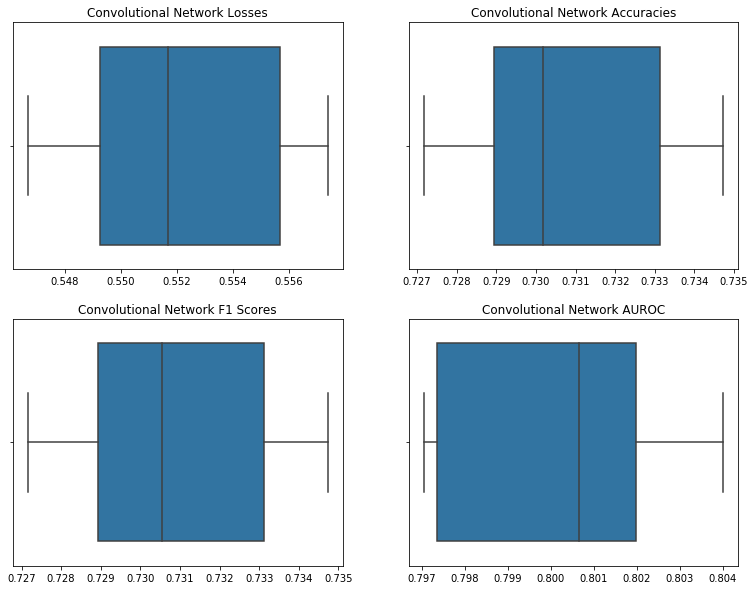

In [8]:
plt.rcParams['figure.figsize'] = [13, 10]
plt.subplot(2, 2, 1)
boxplot(DataFrame(conv_wv_scores['loss'])).set_title("Convolutional Network Losses")
plt.subplot(2, 2, 2)
boxplot(DataFrame(conv_wv_scores['accuracies'])).set_title("Convolutional Network Accuracies")
plt.subplot(2, 2, 3)
boxplot(DataFrame(conv_wv_scores['f1'])).set_title("Convolutional Network F1 Scores")
plt.subplot(2, 2, 4)
boxplot(DataFrame(conv_wv_scores['auroc'])).set_title("Convolutional Network AUROC")
plt.show()

In [51]:
epochs = 5
steps = 293
full_dataset = tf.data.TFRecordDataset(filenames).map(_decode_record).repeat(epochs).batch(46)

Now let's try the model on unseen data:

In [58]:
conv_model = get_conv_wv_model()
history = conv_model.fit(full_dataset, steps_per_epoch=10*steps, epochs=epochs)

Epoch 1/5
2930/2930 [==============================] - 336s 115ms/step - loss: 0.6370 - acc: 0.6740 - auroc: 0.7377 - f1: 0.6740
Epoch 2/5
2930/2930 [==============================] - 335s 114ms/step - loss: 0.5921 - acc: 0.6961 - auroc: 0.7655 - f1: 0.6961
Epoch 3/5
2930/2930 [==============================] - 338s 115ms/step - loss: 0.5774 - acc: 0.7068 - auroc: 0.7784 - f1: 0.7068
Epoch 4/5
2930/2930 [==============================] - 338s 115ms/step - loss: 0.5661 - acc: 0.7166 - auroc: 0.7885 - f1: 0.7166
Epoch 5/5
2930/2930 [==============================] - 335s 114ms/step - loss: 0.5543 - acc: 0.7253 - auroc: 0.7985 - f1: 0.7253


In [12]:
steps = 10
epochs = 5
held_dataset = tf.data.TFRecordDataset("conv-320-test.tfrecord").map(_decode_record).batch(100)

In [13]:
evaluation = conv_model.evaluate(held_dataset, steps=steps)
conv_model.metrics_names, evaluation

10/10 [==============================] - 2s 166ms/step


(['loss', 'acc', 'f1', 'auroc'],
 [0.5470670968294143,
  0.7379999935626984,
  0.7379999220371246,
  0.8095299789086339])

The model performs similarly on the unseen data as the data used to create the model. There was some tweaking, so it is not unreasonable that the test result is different to the validation result.